=== Laminar Regime Performance ===
Polynomial (scaled):  Train R² = 0.987, Test R² = 0.503
Physics (Re scaling): Train R² = 0.993, Test R² = 0.993
Recovered Cf ∝ Re^-0.501


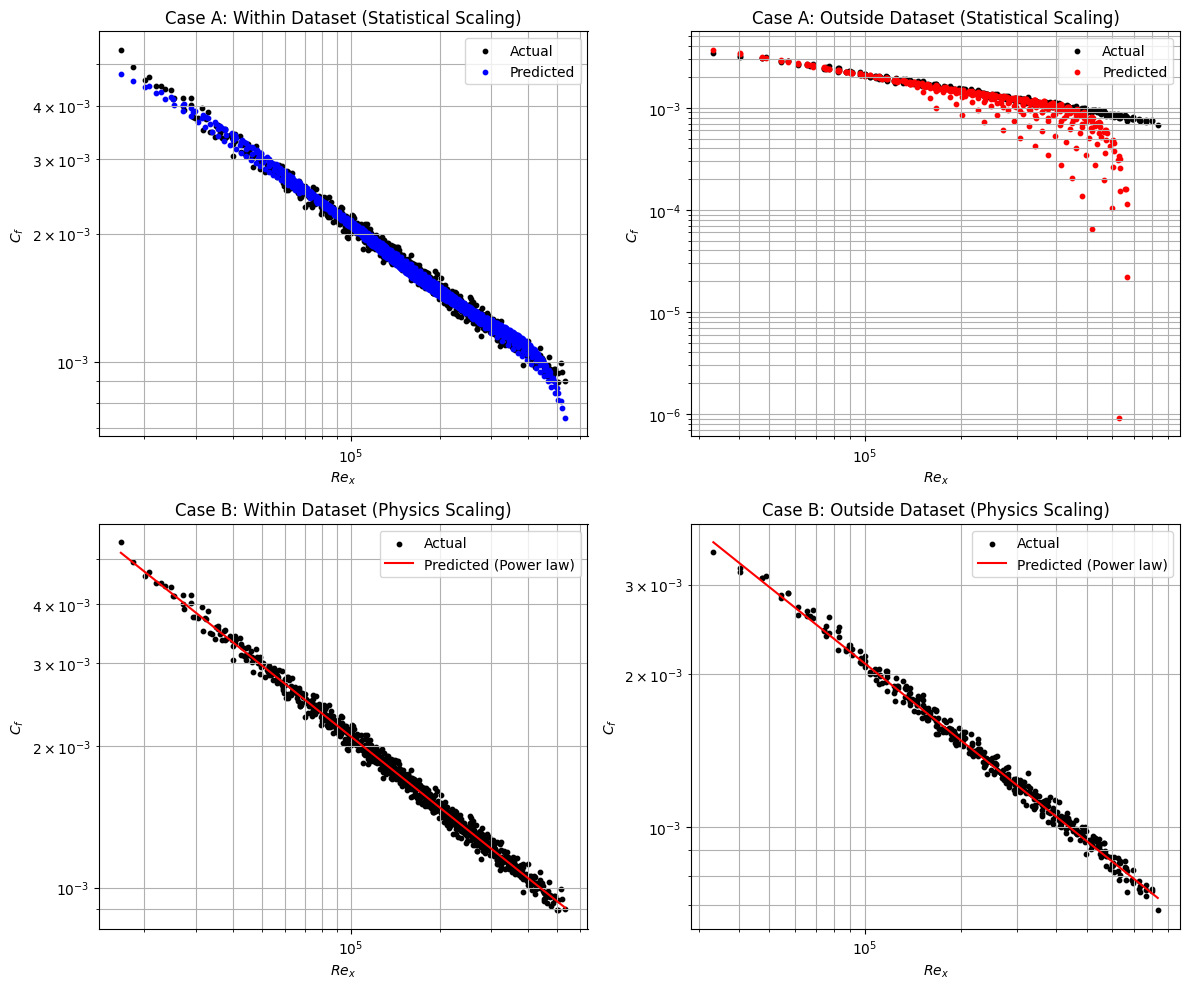

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

np.random.seed(0)
nu = 1.5e-5  # kinematic viscosity [m²/s]

# -------------------------------------------------------
# 1️⃣ Generate laminar training and testing datasets
# -------------------------------------------------------
# Training (laminar regime)
U_train = np.linspace(5, 40, 30)
x_train = np.linspace(0.05, 0.2, 30)

# Slightly outside training range for test
U_test = np.linspace(10, 50, 20)
x_test = np.linspace(0.05, 0.25, 20)

U_tr, x_tr = np.meshgrid(U_train, x_train)
U_te, x_te = np.meshgrid(U_test, x_test)

def generate_cf_laminar(U, x):
    Re = U * x / nu
    Cf = 0.664 / np.sqrt(Re)           # Laminar Blasius scaling
    return Cf * (1 + 0.03*np.random.randn(*Cf.shape))  # add small noise

Cf_train = generate_cf_laminar(U_tr, x_tr)
Cf_test  = generate_cf_laminar(U_te, x_te)

# Flatten arrays
U_tr, x_tr, Cf_train = U_tr.ravel(), x_tr.ravel(), Cf_train.ravel()
U_te, x_te, Cf_test  = U_te.ravel(), x_te.ravel(), Cf_test.ravel()

# -------------------------------------------------------
# 2️⃣ Case A: Statistical scaling + polynomial fit
# -------------------------------------------------------
scaler = MinMaxScaler()
X_train = np.vstack([U_tr, x_tr, np.full_like(U_tr, nu)]).T
X_test  = np.vstack([U_te, x_te, np.full_like(U_te, nu)]).T

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

model_poly = LinearRegression().fit(X_train_poly, Cf_train)
Cf_pred_train_poly = model_poly.predict(X_train_poly)
Cf_pred_test_poly  = model_poly.predict(X_test_poly)

# -------------------------------------------------------
# 3️⃣ Case B: Physics-based scaling (Reynolds number)
# -------------------------------------------------------
Re_train = (U_tr * x_tr / nu)
Re_test  = (U_te * x_te / nu)

logRe_train, logCf_train = np.log(Re_train).reshape(-1,1), np.log(Cf_train)
model_phys = LinearRegression().fit(logRe_train, logCf_train)
a, b = model_phys.intercept_, model_phys.coef_.item()

Cf_pred_train_phys = np.exp(a) * Re_train**b
Cf_pred_test_phys  = np.exp(a) * Re_test**b

# -------------------------------------------------------
# 4️⃣ Performance
# -------------------------------------------------------
print("=== Laminar Regime Performance ===")
print(f"Polynomial (scaled):  Train R² = {r2_score(Cf_train, Cf_pred_train_poly):.3f}, Test R² = {r2_score(Cf_test, Cf_pred_test_poly):.3f}")
print(f"Physics (Re scaling): Train R² = {r2_score(Cf_train, Cf_pred_train_phys):.3f}, Test R² = {r2_score(Cf_test, Cf_pred_test_phys):.3f}")
print(f"Recovered Cf ∝ Re^{b:.3f}")

# -------------------------------------------------------
# 5️⃣ Visualization: Cf vs Re
# -------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12,10))

# CASE A — Statistical scaling
axs[0,0].scatter(Re_train, Cf_train, color='black', s=10, label='Actual')
axs[0,0].scatter(Re_train, Cf_pred_train_poly, color='blue', s=10, label='Predicted')
axs[0,0].set_xscale('log'); axs[0,0].set_yscale('log')
axs[0,0].set_title("Case A: Within Dataset (Statistical Scaling)")
axs[0,0].set_xlabel("$Re_x$"); axs[0,0].set_ylabel("$C_f$")
axs[0,0].legend(); axs[0,0].grid(True, which='both')

axs[0,1].scatter(Re_test, Cf_test, color='black', s=10, label='Actual')
axs[0,1].scatter(Re_test, Cf_pred_test_poly, color='red', s=10, label='Predicted')
axs[0,1].set_xscale('log'); axs[0,1].set_yscale('log')
axs[0,1].set_title("Case A: Outside Dataset (Statistical Scaling)")
axs[0,1].set_xlabel("$Re_x$"); axs[0,1].set_ylabel("$C_f$")
axs[0,1].legend(); axs[0,1].grid(True, which='both')

# CASE B — Physics-based scaling
axs[1,0].scatter(Re_train, Cf_train, color='black', s=10, label='Actual')
axs[1,0].plot(np.sort(Re_train), np.exp(a)*np.sort(Re_train)**b, 'r', label='Predicted (Power law)')
axs[1,0].set_xscale('log'); axs[1,0].set_yscale('log')
axs[1,0].set_title("Case B: Within Dataset (Physics Scaling)")
axs[1,0].set_xlabel("$Re_x$"); axs[1,0].set_ylabel("$C_f$")
axs[1,0].legend(); axs[1,0].grid(True, which='both')

axs[1,1].scatter(Re_test, Cf_test, color='black', s=10, label='Actual')
axs[1,1].plot(np.sort(Re_test), np.exp(a)*np.sort(Re_test)**b, 'r', label='Predicted (Power law)')
axs[1,1].set_xscale('log'); axs[1,1].set_yscale('log')
axs[1,1].set_title("Case B: Outside Dataset (Physics Scaling)")
axs[1,1].set_xlabel("$Re_x$"); axs[1,1].set_ylabel("$C_f$")
axs[1,1].legend(); axs[1,1].grid(True, which='both')

plt.tight_layout()
plt.show()
